# Causal Analysis of Synthetic Dataset

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

from utils import treatment_effect

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

#TREATMENT_COL = 'ContinentOfBirth'
TREATMENT_COL = 'CitizenshipContinent'
TREATMENT_VAL = 'Asia'
treatment_subdimensions = ['CitizenshipCountry'] if TREATMENT_COL == 'CitizenshipContinent' else ['CountryOfBirth']

OUTCOME_NAME = 'Last Name Correct'

TREATMENT = 'T'
OUTCOME = 'O'

In [2]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B-correlation0.7.csv')
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'Last Name Correct'],
      dtype='object')

In [3]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == TREATMENT_VAL
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL, 'Last Name'] + treatment_subdimensions, axis=1).columns.values
CONT_COVARIATES = ['NumChildren']
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [4]:
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'O', 'T'],
      dtype='object')

In [5]:
match_vars = ['CitizenshipContinent'] if TREATMENT_COL == 'ContinentOfBirth' else ['ContinentOfBirth']
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES, additional_excludes=['Last Name'])
#att = treatment_effect.match_exactly(dataset.copy(), TREATMENT, TREATMENT_COL, treatment_subdimensions, OUTCOME, exclude_vars=['Last Name', 'NumChildren'])
att

Formula:
T ~ Source+CountryOfBirth+NumChildren+MaritalStatus
n majority: 2641
n minority: 677
Fitting Models on Balanced Samples: 2\50

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  uf.drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)])


Fitting Models on Balanced Samples: 50\50
Average Accuracy: 53.14%
Covariate MaritalStatus not balanced enough in stratum 0. p-value 0.033135
Formula:
T ~ Source+CountryOfBirth+NumChildren+MaritalStatus
n majority: 2978
n minority: 340
Fitting Models on Balanced Samples: 50\50
Average Accuracy: 53.95%
Formula:
T ~ Source+CountryOfBirth+NumChildren+MaritalStatus
n majority: 3044
n minority: 320
Fitting Models on Balanced Samples: 50\50
Average Accuracy: 54.33%
Covariate Source not balanced enough in stratum 2. p-value 0.038374


-0.010145980953075612

#### Get statistical significance by comparing with placebo treatment

In [7]:
n_iter = 50
def generate_placebo_sample(placebo_data):
    placebo_data[TREATMENT] = np.random.randint(0, 2, len(placebo_data))
    #return match_then_stratify(placebo_data, match_vars, n_models=2)
    return treatment_effect.match_exactly(placebo_data, TREATMENT, TREATMENT_COL, treatment_subdimensions, OUTCOME, 
                                          exclude_vars=['Last Name', 'NumChildren'])
placebo_results = Parallel(n_jobs=4)(delayed(generate_placebo_sample)(dataset.copy()) for _ in range(n_iter))

In [8]:
if (np.percentile(placebo_results, 2.5) <= att <= np.percentile(placebo_results, 97.5)):
    print('Treatment effect within 95%-bounds of placebo effect: {} <= {} <= {}'.format(np.percentile(placebo_results, 2.5), att, np.percentile(placebo_results, 97.5)))
else:
    print('Treatment effect outside 95%-bounds of placebo effect: {} not in [{}, {}]'.format(att, np.percentile(placebo_results, 2.5), np.percentile(placebo_results, 97.5)))

Treatment effect within 95%-bounds of placebo effect: -0.010959346085125408 <= -0.010145980953075612 <= 0.01375601879072358


In [12]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=1, replace=True), match_vars, TREATMENT, 
                                                                                     TREATMENT_COL, treatment_subdimensions, OUTCOME, CONT_COVARIATES, 
                                                                                     CAT_COVARIATES, additional_excludes=['Last Name'], n_models=2) for _ in  range(n_iter))
#treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_exactly)(dataset.sample(frac=.8, replace=False), TREATMENT, TREATMENT_COL, treatment_subdimensions, 
#                                                              OUTCOME, exclude_vars=['Last Name', 'NumChildren']) for _ in  range(n_iter))

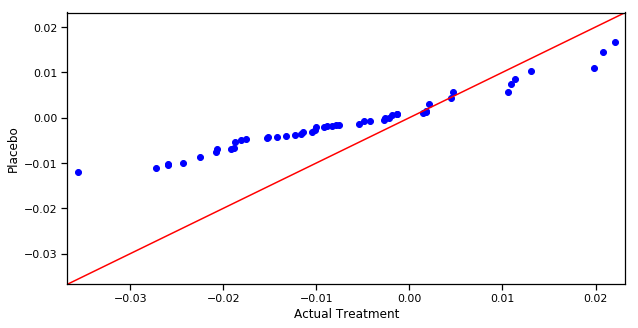

In [13]:
# QQ-Plot to compare empirical distributions. If straight line, no significant difference from placebo treatment.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo', line='45')
pylab.show()

In [14]:
alpha = .05
critical_value = np.sqrt(-np.log(alpha) / 2) * np.sqrt(2 * n_iter/(n_iter * n_iter))

ks_test = scipy.stats.ks_2samp(np.array(placebo_results), np.array(treatment_results))
if ks_test[0] > critical_value and ks_test[1] < alpha:
    print('Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: {:.5f}, p-value: {})'.format(ks_test[0], ks_test[1]))
else: 
    print('Cannot reject hypothesis that placebo and actual treatment are of identical distribution (K-S statistic: {:.5f}, p-value: {})'.format(ks_test[0], ks_test[1]))

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 0.42000, p-value: 0.00017778374204348708)
